# **Scenario Tree with Doob-Meyer decomposition using United Kindom wind data**

This notebook demonstrates the application of a custom Scenario Tree library built to support stochastic modeling and decision-making under uncertainty. The example focuses on constructing a Scenario Tree using the Doob-Meyer decomposition, leveraging real-world United Kingdom wind power data as the stochastic input. To model temporal dynamics, it integrates the Tiny Time Mixer model developed by IBM, which provides a compact yet expressive framework for time series forecasting.


In [1]:
import os
import sys

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from copulas.multivariate import GaussianMultivariate
from scipy.stats import kurtosis, skew

sys.path.append(os.path.join("..", "..", "src", "predictive"))
sys.path.append(os.path.join("..", "..", "src", "martingale"))
sys.path.append(os.path.join("..", "..", "src", "tree"))

from copula_model import CopulaModel
from tiny_time_mixers_predictive_model import (TinyTimeMixersConfig,
                                               TinyTimeMixersPredictiveModel)
from constraint import SolverType, IntervalConstraint
from tree import ScenarioTree

c:\Users\tomma\AppData\Local\pypoetry\Cache\virtualenvs\scenario-generation-6k6Heli7-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
plt.style.use("fivethirtyeight")

DATA_TO_PLOT = 600  # number of time steps to plot
SEED = 42 # random seed for reproducibility
BACKCAST_LENGTH = 512  # context length for the Tiny Time Mixer model
FORECAST_LENGTH = 96  # forecast horizon for the Tiny Time Mixer model

np.random.seed(SEED)
torch.manual_seed(SEED)

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## **Step 1: Data Loading and Preprocessing for the Anticipative Process**

In this initial step, we load the United Kingdom wind power dataset, which serves as the stochastic input for our scenario tree construction. The preprocessing pipeline transforms the raw time series into a format suitable for modeling anticipative processes. This includes:

- 📥 Loading the wind power data from its source
- 🧹 Cleaning and handling missing values or anomalies
- 📊 Normalizing or scaling the data to ensure consistency
- 🕰️ Structuring the time series to align with the anticipative framework
- 🔁 Segmenting the data for training the Tiny Time Mixer model

This step ensures the data is ready for decomposition via the Doob-Meyer process, enabling the generation of realistic and statistically grounded scenario trees.

In [3]:
data = pd.read_csv(os.path.join(".", "..", "..", "data", "UK_data.csv"))
data["time"] = pd.to_datetime(data["time"])
data.drop(columns=["dayofweek", "hour", "month", "GB_demand"], inplace=True)
data.head()

,GB_solar,GB_wind,time
0,0.0,0.6827,2015-01-01 00:00:00
1,0.0,0.6759,2015-01-01 01:00:00
2,0.0,0.6666,2015-01-01 02:00:00
3,0.0,0.6562,2015-01-01 03:00:00
4,0.0,0.6532,2015-01-01 04:00:00


In [4]:
model_input = data.copy()
timestamp_column = "time"
target_columns = [col for col in model_input.columns if col != timestamp_column]
print(f"Timestamp column: {timestamp_column}")
print(f"Target columns: {target_columns}")

Timestamp column: time
Target columns: ['GB_solar', 'GB_wind']


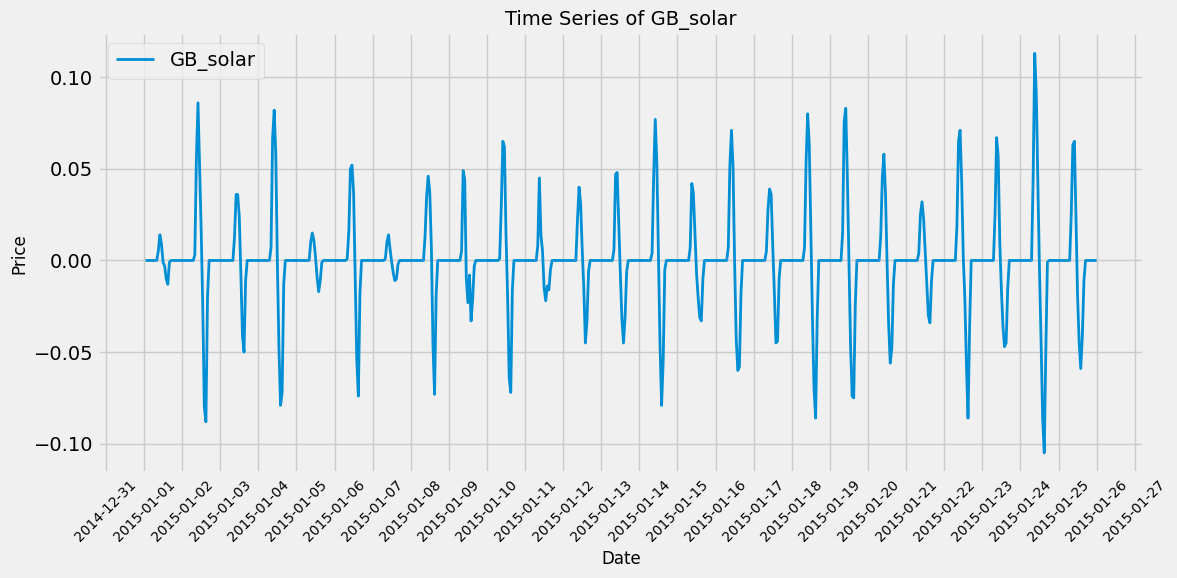

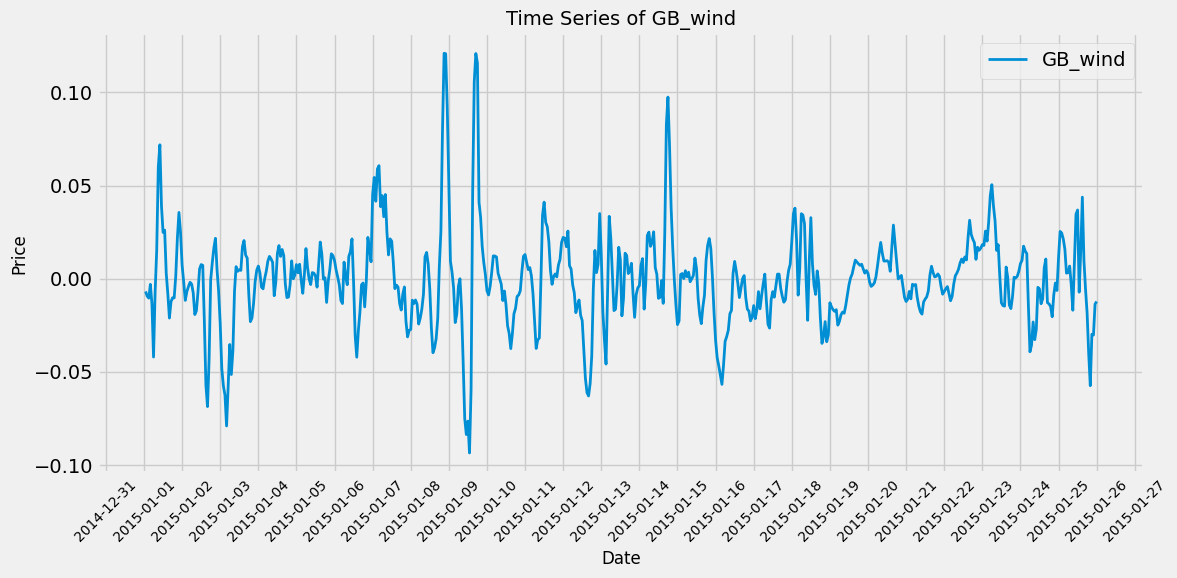

In [5]:
for col in target_columns:
    model_input[col] = model_input[col].diff(1)
    
model_input.dropna(inplace=True)

for col in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(
        model_input[timestamp_column][:DATA_TO_PLOT],
        model_input[col][:DATA_TO_PLOT],
        label=col,
        linewidth=2,
    )

    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title(f"Time Series of {col}", fontsize=14)
    plt.legend()
    # Set major ticks every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    # Set minor ticks every day and use shorter labels
    plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    # Rotate and adjust tick label size
    plt.tick_params(axis="x", which="major", rotation=45, labelsize=10)
    plt.tick_params(axis="x", which="minor", rotation=45, labelsize=8)

    plt.tight_layout()
    plt.show()

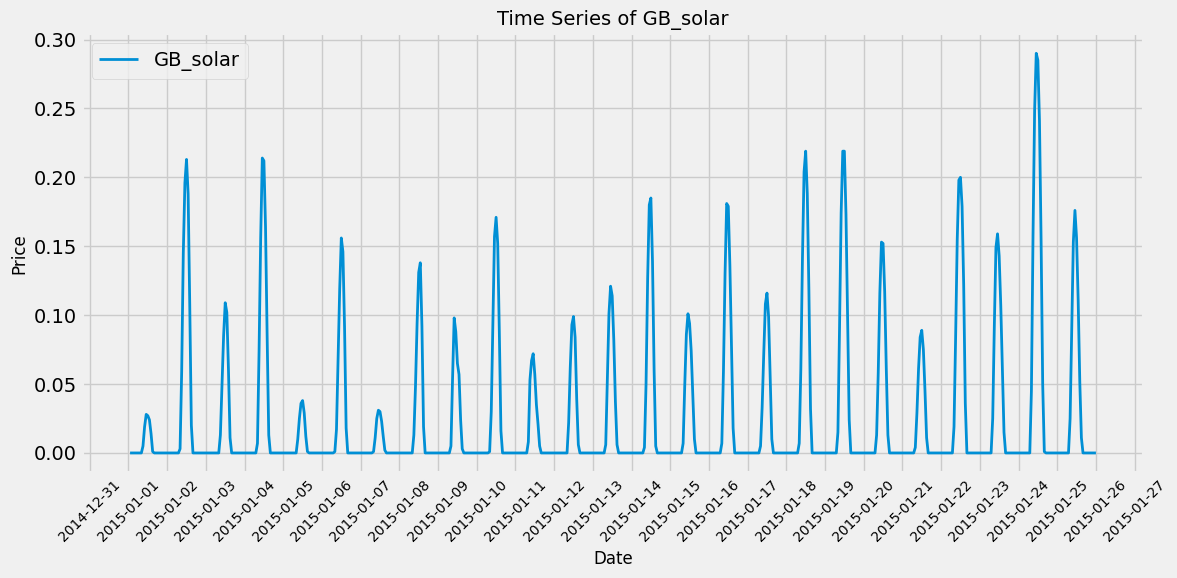

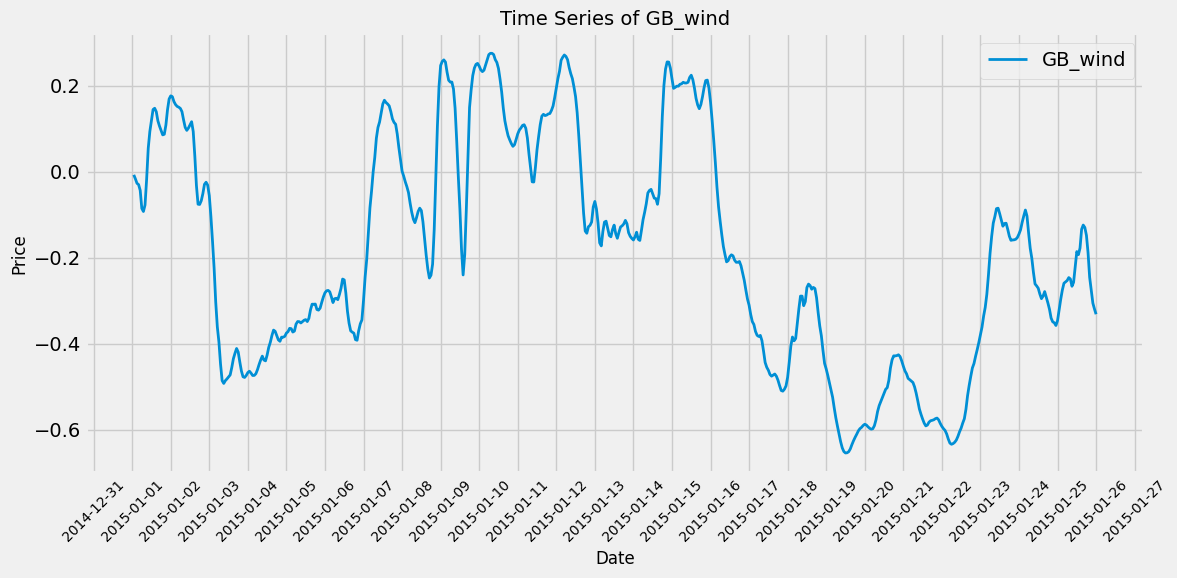

In [6]:
for col in target_columns:
    model_input[col] = np.cumsum(model_input[col].values)
    
for col in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(
        model_input[timestamp_column][:DATA_TO_PLOT],
        model_input[col][:DATA_TO_PLOT],
        label=col,
        linewidth=2,
    )

    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title(f"Time Series of {col}", fontsize=14)
    plt.legend()
    # Set major ticks every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    # Set minor ticks every day and use shorter labels
    plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    # Rotate and adjust tick label size
    plt.tick_params(axis="x", which="major", rotation=45, labelsize=10)
    plt.tick_params(axis="x", which="minor", rotation=45, labelsize=8)

    plt.tight_layout()
    plt.show()

## **Step 2: Defining the Predictive Process for the Doob-Meyer A Component**
In this step, we define the predictive process used to estimate the A component of the Doob-Meyer decomposition, which represents the predictable (or compensator) part of the stochastic process.

To achieve this, we employ the Tiny Time Mixer model developed by IBM, leveraging its zero-shot configuration. This setup allows the model to generate forecasts without requiring task-specific fine-tuning, making it ideal for rapid prototyping and generalization across time series domains.

Key actions in this step include:
- 🧠 Initializing the Tiny Time Mixer in zero-shot mode
- 📈 Feeding the preprocessed wind data into the model
- 🔍 Extracting the anticipative predictions that form the A component
- 🔄 Preparing the output for integration into the scenario tree construction

This predictive layer is crucial for accurately modeling the evolution of the wind power process and ensuring the scenario tree reflects realistic future trajectories.

In [7]:
ttm_config = TinyTimeMixersConfig(
    backcast_length=BACKCAST_LENGTH,
    forecast_length=FORECAST_LENGTH,
    batch_size=64,
    num_epochs=50,
    learning_rate=0,
    dropout=0,
    early_stopping_patience=None,
    early_stopping_threshold=None,
    device=device,
    exogenous_variables=False,
    model_revision="512-96-ft-r2.1",
    decoder_mode="common_channel",
    fcm_context_length=1,
    fcm_mix_layers=2,
    resolution_prefix_tuning=False,
    fcm_use_mixer=True,
    enable_forecast_channel_mixing=False,
    fcm_prepend_past=True,
)

In [8]:
predictive_model = TinyTimeMixersPredictiveModel(
    target_columns=target_columns,
    timestamp_column=timestamp_column,
    control_columns=[],
    ttm_config=ttm_config,
)

In [9]:
split_config = {"train": [0, 0.3], "valid": [0.3, 0.4], "test": [0.4, 1.0]}
train_df, valid_df, test_df = predictive_model.get_dataset_as_dataframe(
    model_input, split_config=split_config
)

train_dataset, valid_dataset, test_dataset = predictive_model.get_dataset(
    model_input,
    split_config
)
print(
    f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}"
)

Data lengths: train = 12539, val = 4288, test = 26199


In [10]:
predictions = predictive_model.predict(train_df, dropna=True)
predictions[timestamp_column] = pd.to_datetime(
    data[BACKCAST_LENGTH : len(train_df)][timestamp_column].values
)
predictions.set_index(timestamp_column, inplace=True)
predictions.reset_index(inplace=True)
predictions.head()

Device set to use cpu


,time,GB_solar,GB_wind,GB_solar_prediction,GB_wind_prediction
0,2015-01-22 08:00:00,0.084,-0.6236,0.046034,-0.620714
1,2015-01-22 09:00:00,0.155,-0.6151,0.109477,-0.617148
2,2015-01-22 10:00:00,0.198,-0.6045,0.152668,-0.606714
3,2015-01-22 11:00:00,0.200,-0.5958,0.161852,-0.594232
4,2015-01-22 12:00:00,0.179,-0.5841,0.141193,-0.586410


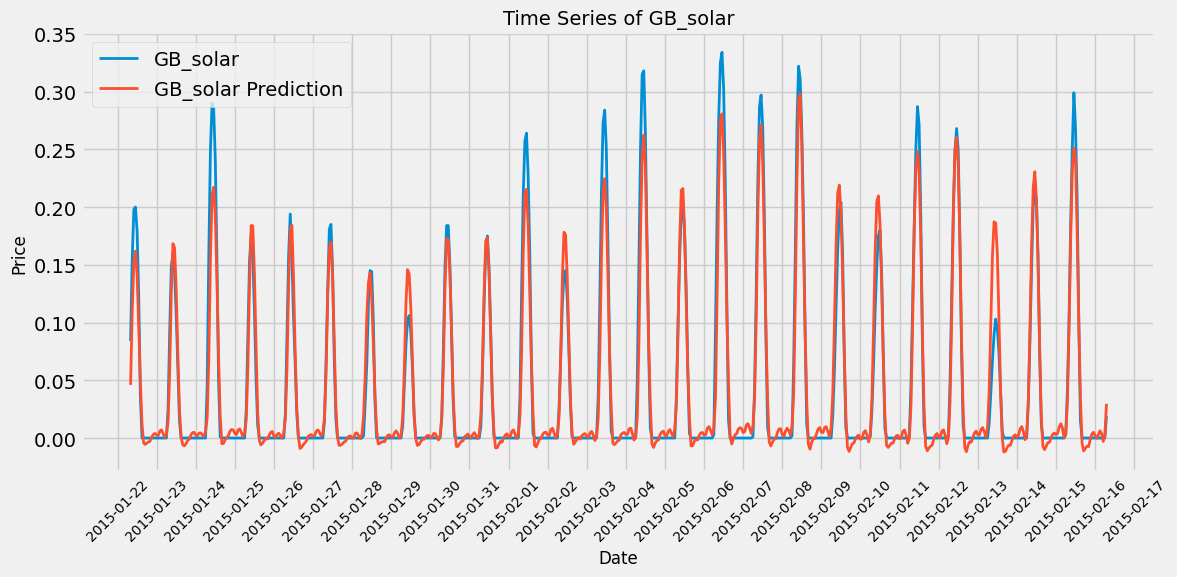

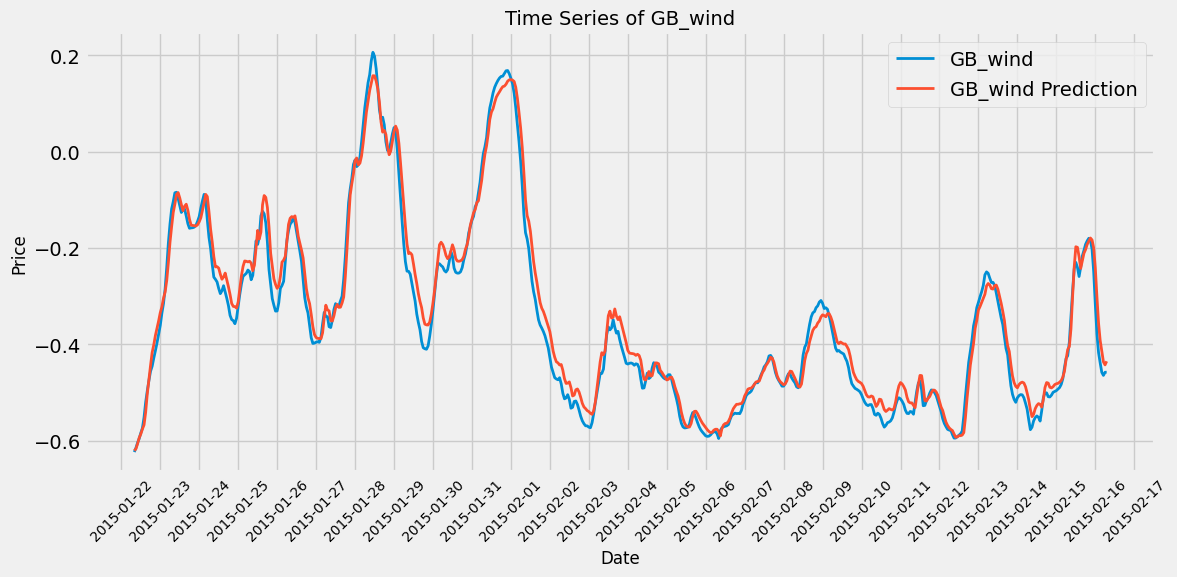

In [11]:
for col in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(
        predictions[timestamp_column][:DATA_TO_PLOT],
        predictions[col][:DATA_TO_PLOT],
        label=col,
        linewidth=2,
    )

    plt.plot(
        predictions[timestamp_column][:DATA_TO_PLOT],
        predictions[f"{col}_prediction"][:DATA_TO_PLOT],
        label=f"{col} Prediction",
        linewidth=2,
    )

    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title(f"Time Series of {col}", fontsize=14)
    plt.legend()
    # Set major ticks every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    # Set minor ticks every day and use shorter labels
    plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    # Rotate and adjust tick label size
    plt.tick_params(axis="x", which="major", rotation=45, labelsize=10)
    plt.tick_params(axis="x", which="minor", rotation=45, labelsize=8)

    plt.tight_layout()
    plt.show()

## **Step 3: Computing the Martingale Difference and Modeling Its Distribution**

In this step, we compute the martingale difference component of the Doob-Meyer decomposition, which captures the unpredictable, noise-like fluctuations in the stochastic process. This residual is obtained by subtracting the predictable A component (estimated via the Tiny Time Mixer) from the original wind power signal.

Once the martingale difference is extracted, we proceed with:

- 📈 Statistical analysis of its distribution, including visual inspection (e.g., histograms, QQ plots) and summary statistics
- 🧪 Goodness-of-fit testing across candidate distributions (e.g., Gaussian, Laplace, Student's t)
- 🧠 Model selection using criteria such as AIC, BIC, or log-likelihood to identify the best-fitting distribution
- 🔮 Parameter estimation for the selected model to enable realistic sampling during scenario generation

This step is crucial for ensuring that the stochastic component of the scenario tree reflects the true uncertainty structure of the wind power process.

In [12]:
def martingale_difference(real_value, predicted_value):
    return real_value - predicted_value

In [13]:
martingale = {col: np.array([]) for col in target_columns}

for col in target_columns:
    M = np.zeros((len(predictions)))
    X = data[col].values
    for t in range(len(predictions)):
        M[t] = martingale_difference(
            data[col].values[t + BACKCAST_LENGTH],
            predictions[f"{col}_prediction"].values[t] + data[col][0],
        )

    martingale[col] = np.asarray(M.flatten())
    martingale[col] = np.array([0 if np.isnan(p) else p for p in martingale[col]])

martingale_df = pd.DataFrame(martingale)
martingale_df[timestamp_column] = predictions[timestamp_column]
martingale_df.head()

,GB_solar,GB_wind,time
0,-0.027034,-0.007986,2015-01-22 08:00:00
1,-0.025477,-0.006452,2015-01-22 09:00:00
2,0.002332,-0.008386,2015-01-22 10:00:00
3,0.036148,-0.010268,2015-01-22 11:00:00
4,0.058807,-0.009390,2015-01-22 12:00:00


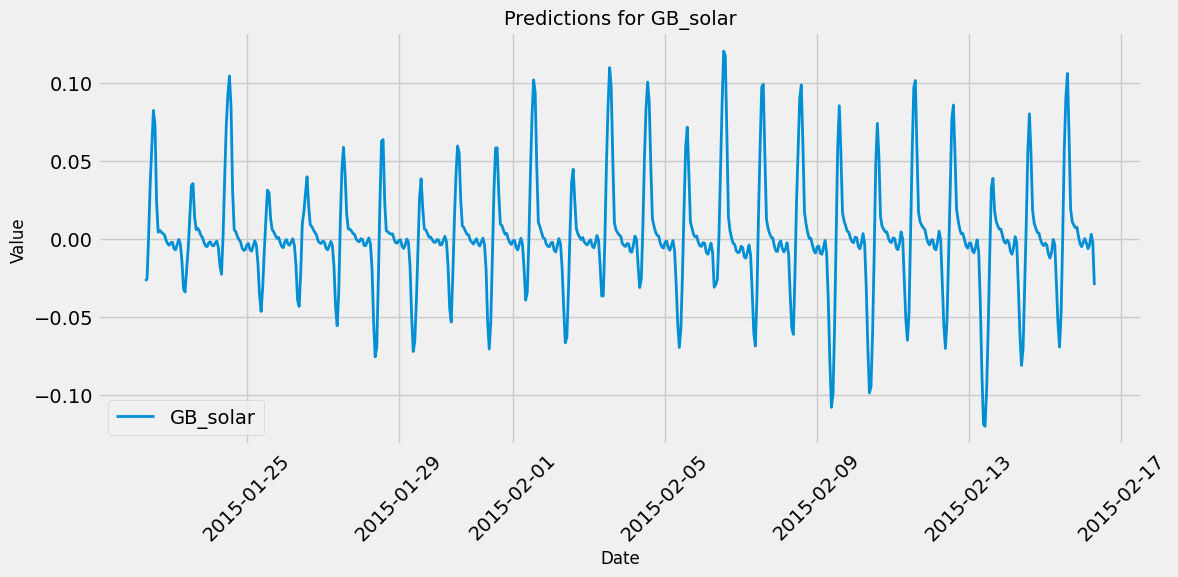

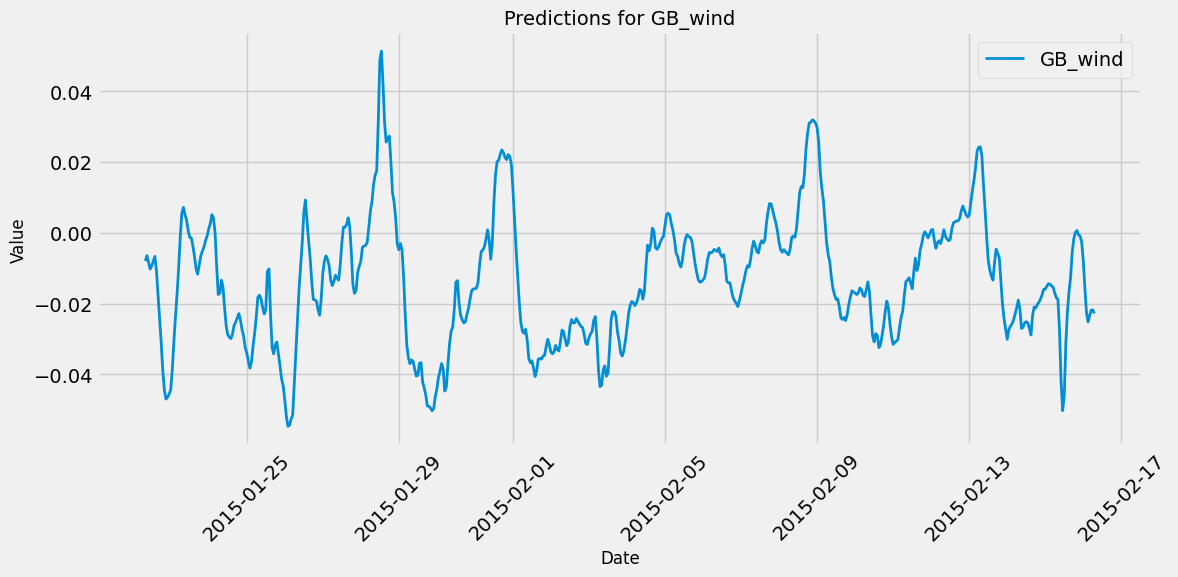

In [14]:
for col in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(
        martingale_df[timestamp_column][:DATA_TO_PLOT],
        martingale_df[col][:DATA_TO_PLOT],
        label=col,
        linewidth=2,
    )

    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title(f"Predictions for {col}", fontsize=14)
    plt.legend()

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

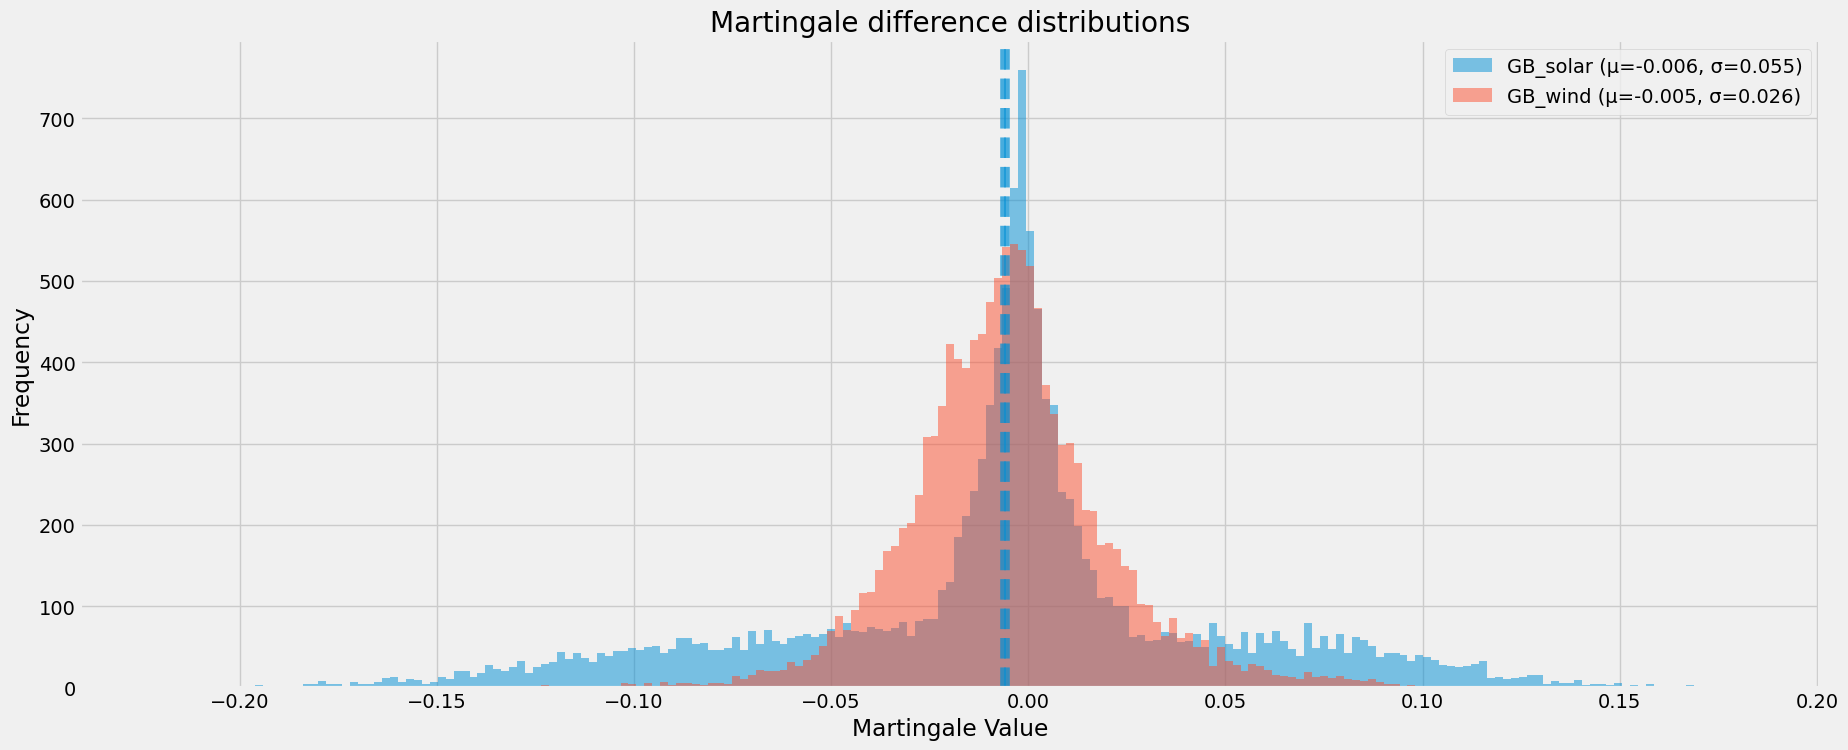

In [15]:
means = {}
stds = {}

for col in target_columns:
    means[col] = np.mean(martingale[col])
    stds[col] = np.std(martingale[col])

all_values = np.concatenate([martingale[col] for col in target_columns])
bin_min, bin_max = np.min(all_values), np.max(all_values)
bins = np.linspace(bin_min, bin_max, 200)

plt.figure(figsize=(20, 8))
for col in target_columns:
    plt.hist(
        martingale[col],
        bins=bins,
        alpha=0.5,
        label=f"{col} (μ={means[col]:.3f}, σ={stds[col]:.3f})",
    )
    plt.axvline(x=means[col], linestyle="--", alpha=0.7)

plt.legend()
plt.title("Martingale difference distributions")
plt.xlabel("Martingale Value")
plt.ylabel("Frequency")
plt.show()

In [16]:
print(
    f"{'Column':<20} {'Mean':>10} {'Std':>10} {'Count':>10} {'Skewness':>12} {'Kurtosis':>12}"
)
print("-" * 84)

for col in target_columns:
    mean_val = means[col]
    std_val = stds[col]
    count_val = len(martingale[col])
    skew_val = skew(martingale[col])
    kurt_val = kurtosis(martingale[col])

    print(
        f"{col:<20} {mean_val:>10.3f} {std_val:>10.3f} {count_val:>10} {skew_val:>12.3f} {kurt_val:>12.3f}"
    )

Column                     Mean        Std      Count     Skewness     Kurtosis
------------------------------------------------------------------------------------
GB_solar                 -0.006      0.055      12634       -0.287        0.916
GB_wind                  -0.005      0.026      12634        0.190        2.016


In [17]:
copula = GaussianMultivariate(random_state=SEED)
copula.fit(martingale_df[target_columns].values)

mu = martingale_df[target_columns].mean().values
cov = martingale_df[target_columns].cov().values

if mu.shape[0] != cov.shape[0]:
    raise ValueError("Mean vector and covariance matrix dimensions do not match.")

if mu.shape[0] != cov.shape[1]:
    raise ValueError("Mean vector and covariance matrix dimensions do not match.")

martingale_model = CopulaModel(
    mean=mu,
    cov=cov,
    copula=copula,
)

INFO:p-21384:t-18024:gaussian.py:fit:Fitting GaussianMultivariate()
c:\Users\tomma\AppData\Local\pypoetry\Cache\virtualenvs\scenario-generation-6k6Heli7-py3.12\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\tomma\AppData\Local\pypoetry\Cache\virtualenvs\scenario-generation-6k6Heli7-py3.12\Lib\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\tomma\AppData\Local\pypoetry\Cache\virtualenvs\scenario-generation-6k6Heli7-py3.12\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\tomma\AppData\Local\pypoetry\Cache\virtualenvs\scenario-generation-6k6Heli7-py3.12\Li

In [18]:
test_sampled_distribution_df = martingale_model.sample(num_samples=len(martingale_df))

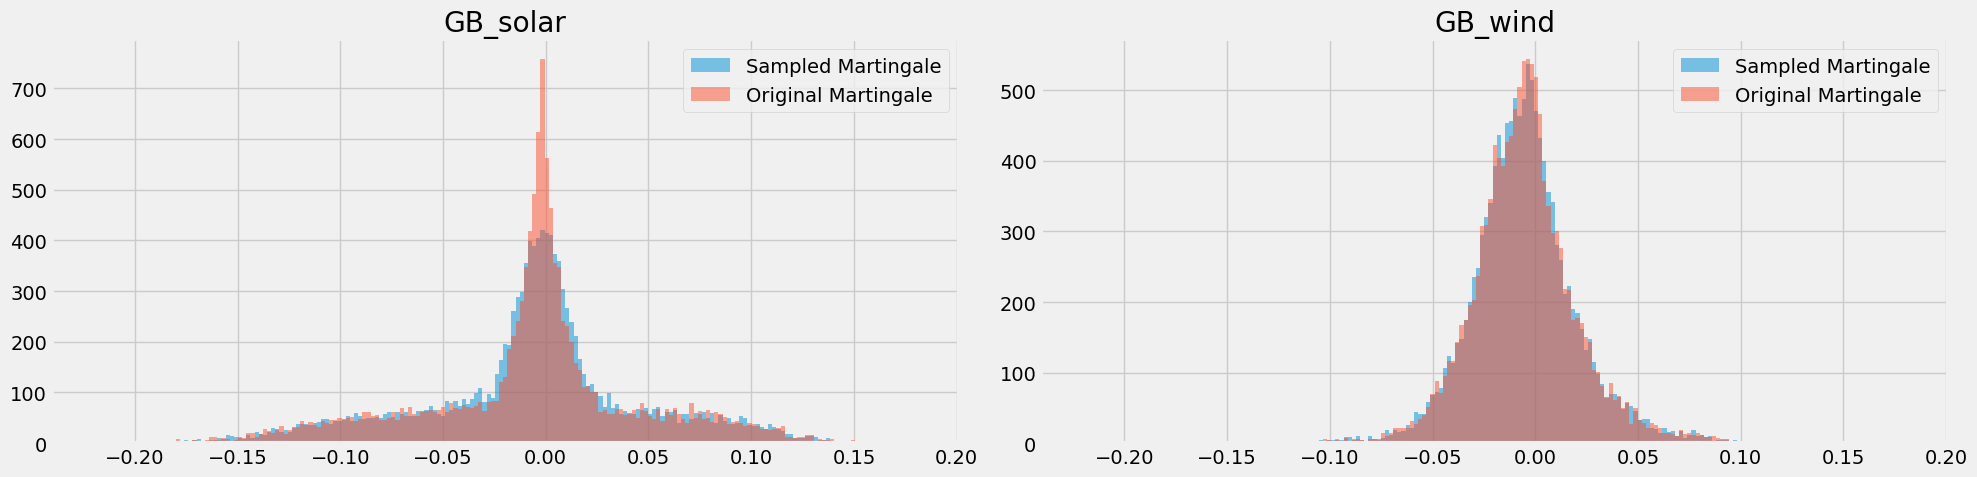

In [19]:
test_sampled_distribution_df = pd.DataFrame(
    test_sampled_distribution_df, columns=target_columns
)

fig, ax = plt.subplots(1, len(martingale_df.columns) - 1, figsize=(20, 5))
for i, col in enumerate(martingale_df.columns[:-1]):
    ax[i].hist(
        test_sampled_distribution_df[col],
        bins=bins,
        alpha=0.5,
        label="Sampled Martingale",
    )
    ax[i].hist(martingale_df[col], bins=bins, alpha=0.5, label="Original Martingale")
    ax[i].set_title(col)
    ax[i].legend()

plt.tight_layout()
plt.show()

## **Step 4: Scenario Tree Construction**

In this final step, we construct the Scenario Tree by combining the predictive process (A component) and the stochastic model of the martingale difference (M component) derived in the previous steps. This tree represents a branching structure of possible future outcomes, enabling robust decision-making under uncertainty.

To ensure statistical reliability and structural depth, the scenario tree construction requires a minimum of 512 data points. This threshold guarantees sufficient variability and resolution across branches.

Key operations include:

- 🔗 Merging the anticipative predictions with sampled martingale noise
- 🌿 Branching the tree based on probabilistic paths derived from the fitted distribution
- 🧩 Structuring the tree to reflect time steps, decision nodes, and outcome scenarios
- 📐 Validating the tree's coherence and coverage of the underlying stochastic process

The resulting scenario tree serves as a powerful tool for downstream optimization, planning, or simulation tasks—especially in energy systems where uncertainty plays a central role.

In [20]:
tree_cols = target_columns
INITIAL_POINT = 50

first_model_input = (
    model_input[tree_cols][-(INITIAL_POINT + 512 + 1) : -(INITIAL_POINT + 1)]
    .to_numpy()
    .transpose()
)

dates = pd.DatetimeIndex(
    model_input[timestamp_column][-(INITIAL_POINT + 512 + 1) : -(INITIAL_POINT + 1)]
)

In [21]:
assert isinstance(first_model_input, np.ndarray), "Model input should be a numpy array"

assert isinstance(dates, pd.DatetimeIndex), "'dates' should be a pandas DatetimeIndex"

tree = ScenarioTree(
    predictive_model=predictive_model,
    martingale_model=martingale_model,
    model_input=first_model_input,
    scenario_value=data[tree_cols].iloc[-INITIAL_POINT].to_numpy(),
    mean_adjustment=True,
    mean_value=mu,
    dates=dates,
    cols_name=tree_cols,
    start_values=data[tree_cols].iloc[0].to_numpy(),
    tree_name="UK_Electricity_Wind_TTM_zs",
    constraints=[
        IntervalConstraint(lower_bound=0, upper_bound=1.0, solver_type=SolverType.CLIP)
    ],
)

INFO:p-21384:t-18024:tree.py:model_post_init:No existing tree named 'UK_Electricity_Wind_TTM_zs'. Creating a new one.
INFO:p-21384:t-18024:tree.py:model_post_init:Database UK_Electricity_Wind_TTM_zs.db setup...
INFO:p-21384:t-18024:tree.py:model_post_init:Database engine created for UK_Electricity_Wind_TTM_zs.db. Creating tables...
INFO:p-21384:t-18024:tree.py:model_post_init:Initialized ScenarioTree database: UK_Electricity_Wind_TTM_zs.db


In [22]:
tree.generate_scenario_tree(num_periods=6, num_scenarios_per_period=3, returns=False, log_value=False)
tree.save_to_file()

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
INFO:p-21384:t-18024:tree.py:_generate_tree_helper:Committed batch of 100 nodes to database
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device

Last ID: 1092
Total scenarios generated: 729


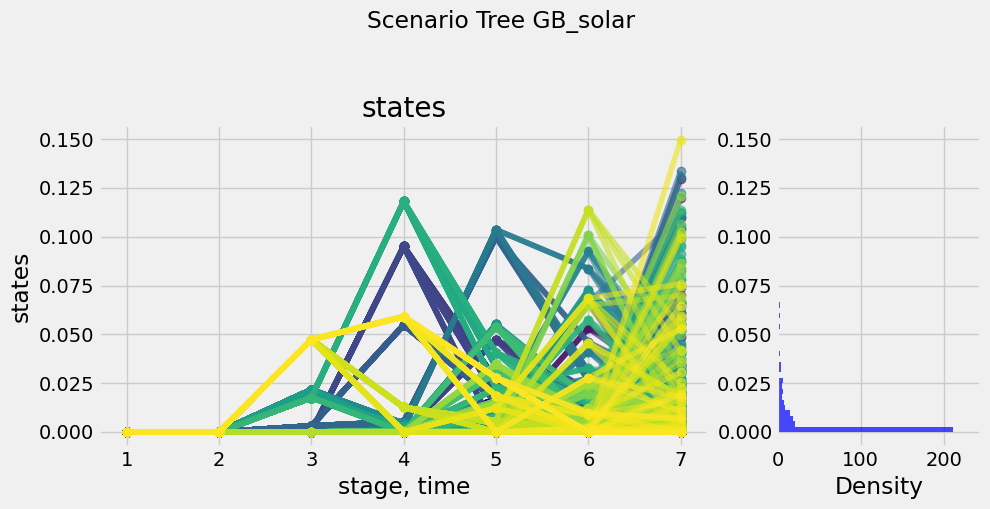

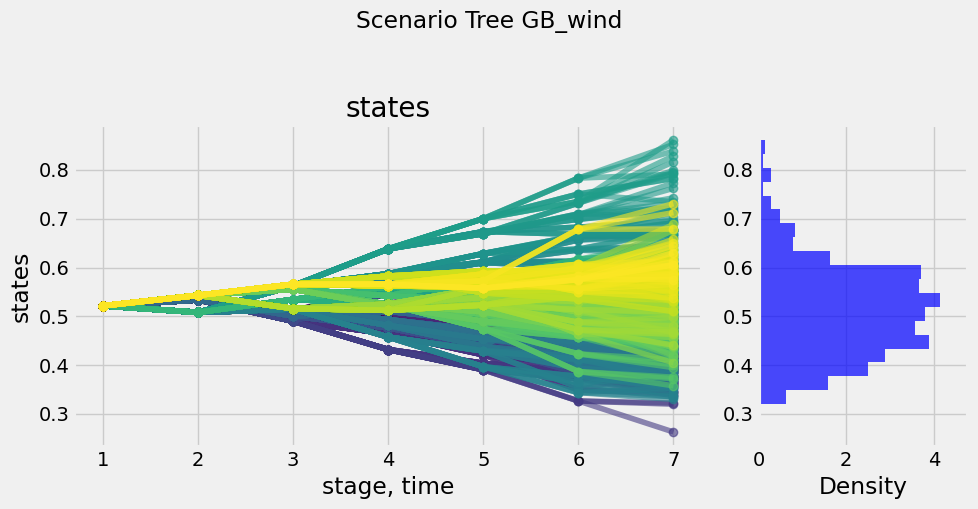

In [23]:
# Visualize the tree
tree.view_scenario_tree(tickers=tree_cols, figsize=(10, 5))